# Convolutional Autoencoder

## Import statements + Device

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from utils import print_np_array_properties
%matplotlib inline


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available Device: {device}')

def split_validation(data):
    
    valid_len = len(data)//2
    test_len = len(data) - valid_len
    valid_data, test_data = torch.utils.data.random_split(data, [valid_len , test_len])
    
    return valid_data, test_data


def imshow(img):
    # img = img/2 +0.5
    
    plt.imshow(np.transpose(img, (1,2,0))) # convert from tensor to image


Available Device: cuda


## Dataset

Files already downloaded and verified
Files already downloaded and verified
torch.Size([20, 3, 32, 32])


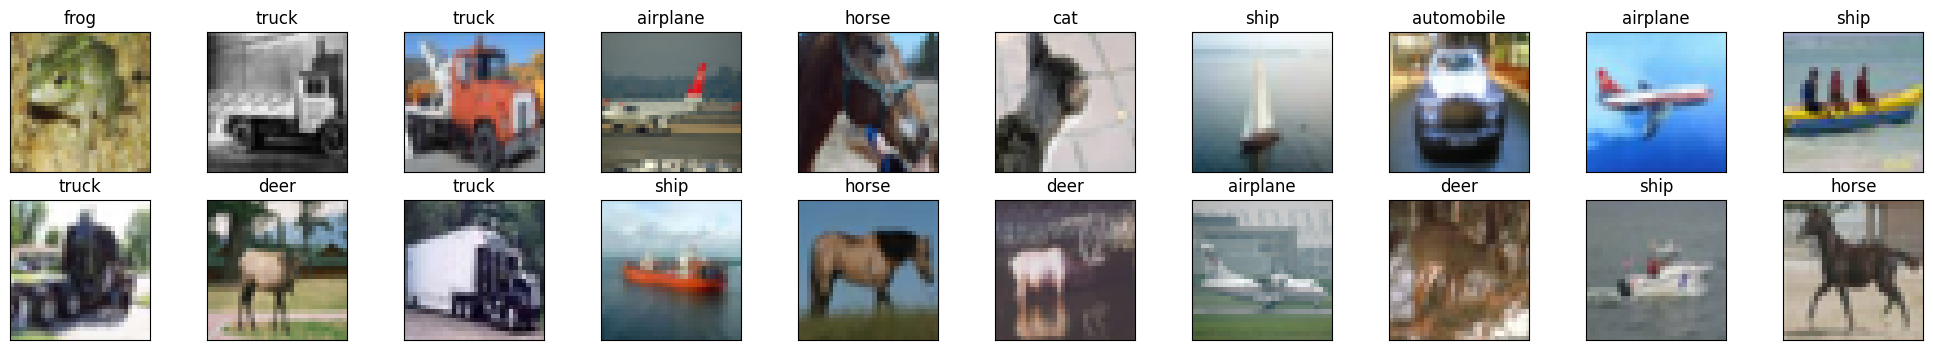

In [2]:
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


## Define preprocessing transformation applied to data
transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform)

validation_data = datasets.CIFAR10( 
    root='data',
    train=False,
    download=True,
    transform=transform)

valid_data, test_data = split_validation(validation_data)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


dataiter = iter(train_loader)
images, label = next(dataiter)

print(images.shape)

fig = plt.figure(figsize=(25,4))

for i in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[label[i]])
    

## Convolutional Autoencoder Architecture

In [3]:
class ConvAE(nn.Module):
    def __init__(self):
        
        super(ConvAE, self).__init__()
        
        self.encoder = nn.Sequential( 
            
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
#             nn.Conv2d(32, 10, 3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
            
#             nn.Conv2d(10, 10, 3, stride=1, padding=1),
#             nn.ReLU(),
            
#             nn.Conv2d(10, 10, 3, stride=1, padding=1),
#             nn.ReLU(),
            
        )
        
        self.decoder = nn.Sequential(
            
            # nn.ConvTranspose2d(10, 32, 2, stride=2),
            # nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.ReLU(),
            
        )
        
    def forward(self,x):
        z = self.encoder(x)
        # print_np_array_properties(z)
        x = self.decoder(z)
        
        return x, z

### Define Model and optimizer

In [4]:
model = ConvAE().to(device)

print(model)

x,z= model(images[i].to(device))

print_np_array_properties(z)
print_np_array_properties(x)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
)
=============== np array Properties =============

n

In [ ]:
n_epochs=60

valid_loss_min = np.Inf

for epoch in range(1, n_epochs):
    
    train_loss=0.0
    valid_loss=0.0
    
    ## Training Step
    model.train()
    for images, _ in train_loader:
        
        images = images.to(device)
        
        optimizer.zero_grad() # clar the gradients of all optimized variables
        x,z = model(images) # Forward pass
        
        loss = loss_func(x, images) # calculate loss of the forward pass
        
        loss.backward() #calculate gradients based on the loss
        
        optimizer.step() # update weights
        
        train_loss += loss.item()*images.size(0)
    ## Validation Step
    
    model.eval()
    for images, _ in valid_loader:
        images = images.to(device)
        
        x,z = model(images) # forward pass
        
        loss = loss_func(x, images)
        
        valid_loss += loss.item() * images.size(0)
    
    # calculate Average loss
    train_loss = train_loss/len(train_loader.dataset) 
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    #Print progress statement
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    #Save model with the lowest validation loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), './data/ConvAE_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.009997 	Validation Loss: 0.005717
Validation loss decreased (inf --> 0.005717).  Saving model ...
Epoch: 2 	Training Loss: 0.005278 	Validation Loss: 0.004461
Validation loss decreased (0.005717 --> 0.004461).  Saving model ...
Epoch: 3 	Training Loss: 0.004764 	Validation Loss: 0.004306
Validation loss decreased (0.004461 --> 0.004306).  Saving model ...
Epoch: 4 	Training Loss: 0.004436 	Validation Loss: 0.004117
Validation loss decreased (0.004306 --> 0.004117).  Saving model ...
Epoch: 5 	Training Loss: 0.004245 	Validation Loss: 0.003918
Validation loss decreased (0.004117 --> 0.003918).  Saving model ...
Epoch: 6 	Training Loss: 0.004138 	Validation Loss: 0.004250
Epoch: 7 	Training Loss: 0.004066 	Validation Loss: 0.003898
Validation loss decreased (0.003918 --> 0.003898).  Saving model ...


### Test output

In [ ]:
model.load_state_dict(torch.load('./data/ConvAE_cifar.pt'))

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output, _ = model(images.to(device))
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.to('cpu').view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.transpose(img, (1,2,0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)